In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from datetime import datetime

import os
import sys
import requests
from tqdm import tqdm  # Para ver el progreso de descarga


project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)


### 1. Preprocesamiento

In [6]:
variant_picturs_df = pd.read_csv('../data/pictures_202506050836.csv')

In [7]:
url_base = "https://www.cheeky.com.ar/uploads/picture/image/"
variant_picturs_df['image_url'] = (
    url_base + variant_picturs_df['id'].astype(str) + "/" + variant_picturs_df['image']
)

variant_picturs_df = variant_picturs_df[variant_picturs_df['position'] == 1.0]

variant_picturs_df

,id,default,image,imageable_type,imageable_id,created_at,updated_at,imageable_id_id,position,alt,image_url
11,411,NaN,V1900251_2_1.png,Variant,225,2018-11-09 19:52:51.875,2018-11-09 19:52:51.875,NaN,1.0,NaN,https://www.cheeky.com.ar/uploads/picture/imag...
12,466,NaN,V1900251_2_1.png,Variant,226,2018-11-12 15:26:18.999,2018-11-12 15:26:18.999,NaN,1.0,NaN,https://www.cheeky.com.ar/uploads/picture/imag...
13,467,NaN,V1900251_2_1.png,Variant,227,2018-11-12 15:26:22.358,2018-11-12 15:26:22.358,NaN,1.0,NaN,https://www.cheeky.com.ar/uploads/picture/imag...
14,468,NaN,V1900251_2_1.png,Variant,228,2018-11-12 15:26:25.625,2018-11-12 15:26:25.625,NaN,1.0,NaN,https://www.cheeky.com.ar/uploads/picture/imag...
15,469,NaN,V1900251_2_1.png,Variant,225,2018-11-12 15:26:28.944,2018-11-12 15:26:28.944,NaN,1.0,NaN,https://www.cheeky.com.ar/uploads/picture/imag...
...,...,...,...,...,...,...,...,...,...,...,...
38159,199922,NaN,I251173170_1.jpg,Variant,109055,2025-05-22 18:33:20.133,2025-05-22 18:33:20.133,NaN,1.0,NaN,https://www.cheeky.com.ar/uploads/picture/imag...
38161,199926,NaN,I250742115_1.jpg,Variant,105714,2025-05-28 15:34:53.828,2025-05-28 17:41:31.763,NaN,1.0,NaN,https://www.cheeky.com.ar/uploads/picture/imag...
38163,199929,NaN,I251156140_1.jpg,Variant,111172,2025-05-28 17:08:13.328,2025-05-28 17:10:08.304,NaN,1.0,NaN,https://www.cheeky.com.ar/uploads/picture/imag...
38165,199931,NaN,I250394163_1.jpg,Variant,109016,2025-06-02 12:53:56.589,2025-06-02 12:53:56.589,NaN,1.0,NaN,https://www.cheeky.com.ar/uploads/picture/imag...


### 2. Extracción de imágenes

In [8]:

# Directorio donde guardarás las imágenes
output_dir = "../data/images"
os.makedirs(output_dir, exist_ok=True)

# Asumiendo que tu DataFrame se llama variant_picturs_df y la columna es 'image_url'
for idx, row in tqdm(variant_picturs_df.iterrows(), total=variant_picturs_df.shape[0]):
    url = row['image_url']
    # Puedes usar el id o el nombre de la imagen para guardarla
    image_name = f"{row['imageable_id']}_{os.path.basename(url)}"
    image_path = os.path.join(output_dir, image_name)
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            with open(image_path, 'wb') as f:
                f.write(response.content)
        else:
            print(f"Error al descargar {url}: status {response.status_code}")
    except Exception as e:
        print(f"Error al descargar {url}: {e}")

  0%|          | 1/16755 [00:03<15:59:36,  3.44s/it]


KeyboardInterrupt: 

### 3. Extracción de features

In [3]:
img_width, img_height = 224, 224

#top_model_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
train_data_dir = "../data/images/"

nb_train_samples = 543
epochs = 50
batch_size = 1

def extract_features():
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import GlobalAveragePooling2D
    
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255)

   # model = applications.ResNet50(include_top=False, weights='imagenet')
    base_model = applications.ResNet50(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
    extracted_features = model.predict(generator, steps=nb_train_samples // batch_size, verbose=1)
    #extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)
    #extracted_features = extracted_features.reshape(543, 100352)
    
    np.save(open('../data/image_vectors/features.npy', 'wb'), extracted_features)
    np.save(open('../data/image_vectors/featuresproduct_ids.npy', 'wb'), np.array(Itemcodes))
    
a = datetime.now()
extract_features()
print("Time taken in feature extraction", datetime.now()-a)

Found 538 images belonging to 1 classes.


2025-06-07 17:19:34.364181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


543/543 [==============================] - 47s 84ms/step
Time taken in feature extraction 0:00:48.302990


In [9]:
# Cargar los features
features = np.load("../data/image_vectors/features.npy")

# Cargar los IDs
product_ids = np.load("../data/image_vectors/featuresproduct_ids.npy")

df = pd.DataFrame(features)
df['product_id'] = product_ids

df.tail()


,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,product_id
533,0.0,0.0,0.000000,0.0,1.161057,0.0,0.0,0.971152,0.000000,0.0,...,0.0,0.0,0.0,0.019055,0.0,0.0,1.700812,0.0,0.0,9974_RackMultipart20181115-1595-jeuw9s
534,0.0,0.0,0.000288,0.0,1.167752,0.0,0.0,0.991408,0.000732,0.0,...,0.0,0.0,0.0,0.020151,0.0,0.0,1.656744,0.0,0.0,9977_RackMultipart20181115-1595-10r43vq
535,0.0,0.0,0.000000,0.0,1.188697,0.0,0.0,0.969227,0.000000,0.0,...,0.0,0.0,0.0,0.017984,0.0,0.0,1.702519,0.0,0.0,9985_RackMultipart20181115-1595-4b00nb
536,0.0,0.0,0.000000,0.0,1.144540,0.0,0.0,0.968465,0.000000,0.0,...,0.0,0.0,0.0,0.018420,0.0,0.0,1.660158,0.0,0.0,9992_RackMultipart20181115-1595-iw1vys
537,0.0,0.0,0.000000,0.0,1.285759,0.0,0.0,1.109681,0.015696,0.0,...,0.0,0.0,0.0,0.032636,0.0,0.0,2.020329,0.0,0.0,9995_RackMultipart20181115-1595-4nmueu


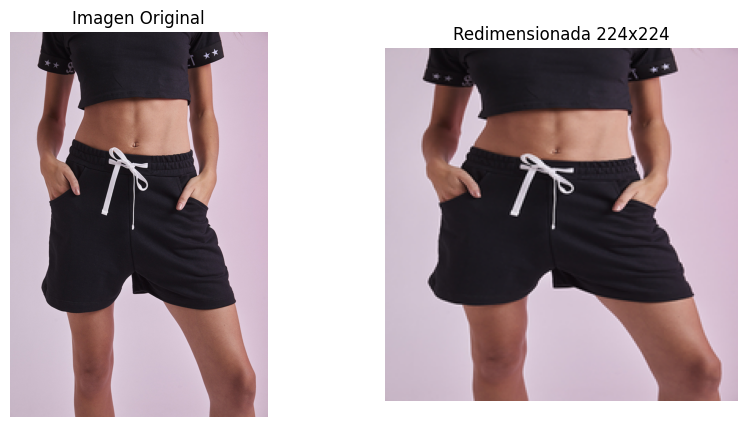

In [45]:
from PIL import Image
import matplotlib.pyplot as plt
import os

train_data_dir = "../data/images/"

# Listar archivos de imagen (solo los primeros)
image_files = []
for root, dirs, files in os.walk(train_data_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))

# Tomar la primera imagen
img_path = image_files[3]

# Abrir imagen original
img_original = Image.open(img_path)

# Redimensionar a 224x224 (sin crop, solo resize)
img_resized = img_original.resize((224, 224), resample=Image.LANCZOS)

# Mostrar lado a lado
fig, axs = plt.subplots(1, 2, figsize=(10,5))

axs[0].imshow(img_original)
axs[0].set_title("Imagen Original")
axs[0].axis('off')

axs[1].imshow(img_resized)
axs[1].set_title("Redimensionada 224x224")
axs[1].axis('off')

plt.show()

### 4. Inserción de features en la base de datos

In [10]:
from src.services.database.vector_db_service import VectorDbService
from src.services.database.models import Item

vdbs = VectorDbService()
client = vdbs.client
client.cluster.health()

x86_64


{'cluster_name': 'docker-cluster',
 'status': 'yellow',
 'timed_out': False,
 'number_of_nodes': 1,
 'number_of_data_nodes': 1,
 'discovered_master': True,
 'discovered_cluster_manager': True,
 'active_primary_shards': 15,
 'active_shards': 15,
 'relocating_shards': 0,
 'initializing_shards': 0,
 'unassigned_shards': 1,
 'delayed_unassigned_shards': 0,
 'number_of_pending_tasks': 0,
 'number_of_in_flight_fetch': 0,
 'task_max_waiting_in_queue_millis': 0,
 'active_shards_percent_as_number': 93.75}

In [12]:
try:
    #client.indices.delete('items')
    Item.init(using=client)
    print("Índice inicializado correctamente.")
except Exception as e:
    print(f"Error al inicializar el índice: {e}")

Índice inicializado correctamente.


In [13]:

features = np.load("../data/image_vectors/features.npy")
item_ids = np.load("../data/image_vectors/featuresproduct_ids.npy")

for idx in range(len(features)):
    try:
        vector = features[idx].tolist()
        variant_id = str(item_ids[idx])
        it = Item(
            variant_id = variant_id,
            #url = row['IMDB URL'],
            #title = row['title'],
            #description = row['description'],
            image_vector = list(vector),
            created_at = datetime.now()
        )
        it.save(using=client)
        #Movie.search(using=client).count()
        #mv.save(using=client)
    except Exception as e:
        print(f"Error al guardar el item {variant_id}: {e}")

Error al guardar el item 10001_RackMultipart20181115-1595-1eyk8c3: TransportError(429, 'cluster_block_exception', 'index [items] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];')
Error al guardar el item 10003_RackMultipart20181115-1595-16ujfky: TransportError(429, 'cluster_block_exception', 'index [items] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];')
Error al guardar el item 10006_RackMultipart20181115-1595-cy76qh: TransportError(429, 'cluster_block_exception', 'index [items] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];')
Error al guardar el item 10010_RackMultipart20181115-1595-hwq7a6: TransportError(429, 'cluster_block_exception', 'index [items] blocked by: [TOO_MANY_REQUESTS/12/disk usage exceeded flood-stage watermark, index has read-only-allow-delete block];')
Error 